# Colour visualisation

In [ ]:
# general
import numpy as np
import matplotlib.pyplot as plt

# custom
from reflectance import spectrum_utils

In [ ]:
algae_sim_spectra = spectrum_utils.simulate_spectra(three_endmember_array, (1, 0, 0))  # Rb values: algae, coral, sand
coral_sim_spectra = spectrum_utils.simulate_spectra(three_endmember_array, (0, 1, 0))  # Rb values: algae, coral, sand
sand_sim_spectra = spectrum_utils.simulate_spectra(three_endmember_array, (0, 0, 1))  # Rb values: algae, coral, sand

all_spectra = np.concatenate([algae_sim_spectra, coral_sim_spectra, sand_sim_spectra], axis=0)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
# calculate the values over red_wvs for all samples
blue_wvs = spectrum_utils.range_from_centre_and_width(492.4, 66)
green_wvs = spectrum_utils.range_from_centre_and_width(559.8, 36)
red_wvs = spectrum_utils.range_from_centre_and_width(664.6, 31)

# wavelengths = np.arange(391, 707, 1)

# reshape array to be (n_samples x n_depths x n_ks x n_bbs x n_noise_levels, n_wvs)
flattened_sim_spectra = all_spectra.reshape(-1, 113)

# interpolated_spectra = interp1d(wvs, flattened_sim_spectra, kind='cubic', axis=-1)(wavelengths)

rgb_values = np.array([rgb_from_hyperspectral(wvs, s, red_wvs, green_wvs, blue_wvs)
                      for s in flattened_sim_spectra])

reds, greens, blues = rgb_values[:, 0], rgb_values[:, 1], rgb_values[:, 2]

In [ ]:
# normalise RGB values to the 1st and 99th percentile of each pair
norm_reds = (reds - np.percentile(reds, 1)) / (np.percentile(reds, 99) - np.percentile(reds, 1))
norm_greens = (greens - np.percentile(greens, 1)) / (np.percentile(greens, 99) - np.percentile(greens, 1))
norm_blues = (blues - np.percentile(blues, 1)) / (np.percentile(blues, 99) - np.percentile(blues, 1))

# min-max normalisation
maxes = np.max([norm_reds, norm_greens, norm_blues], axis=1)
mins = np.min([norm_reds, norm_greens, norm_blues], axis=1)
norm_rgb_values = (np.array([norm_reds, norm_greens, norm_blues]).T - mins) / (maxes - mins)

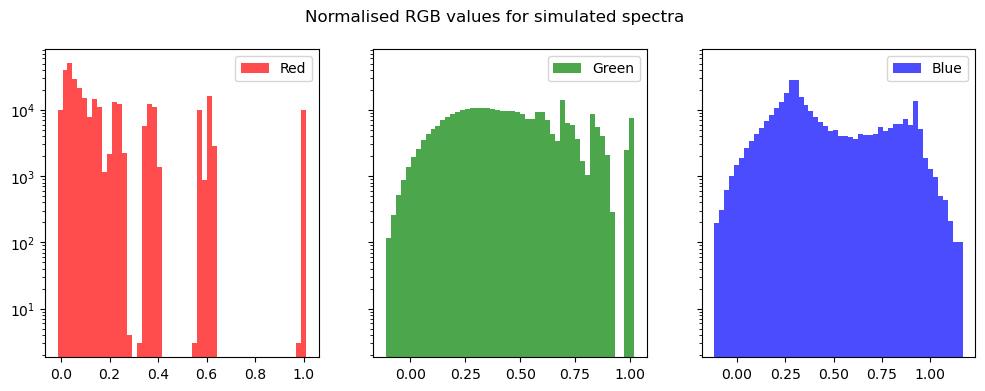

In [ ]:
# plot histogram of red, green, and blue values
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

plt.suptitle("Normalised RGB values for simulated spectra")
for i, (ax, rgb, colour) in enumerate(zip(axs, [norm_reds, norm_greens, norm_blues], ["Red", "Green", "Blue"])):
    ax.hist(rgb, bins=50, color=colour, alpha=0.7, label=colour)
    ax.set_yscale('log')
    ax.legend()
axes[0].set_ylabel("Frequency");

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

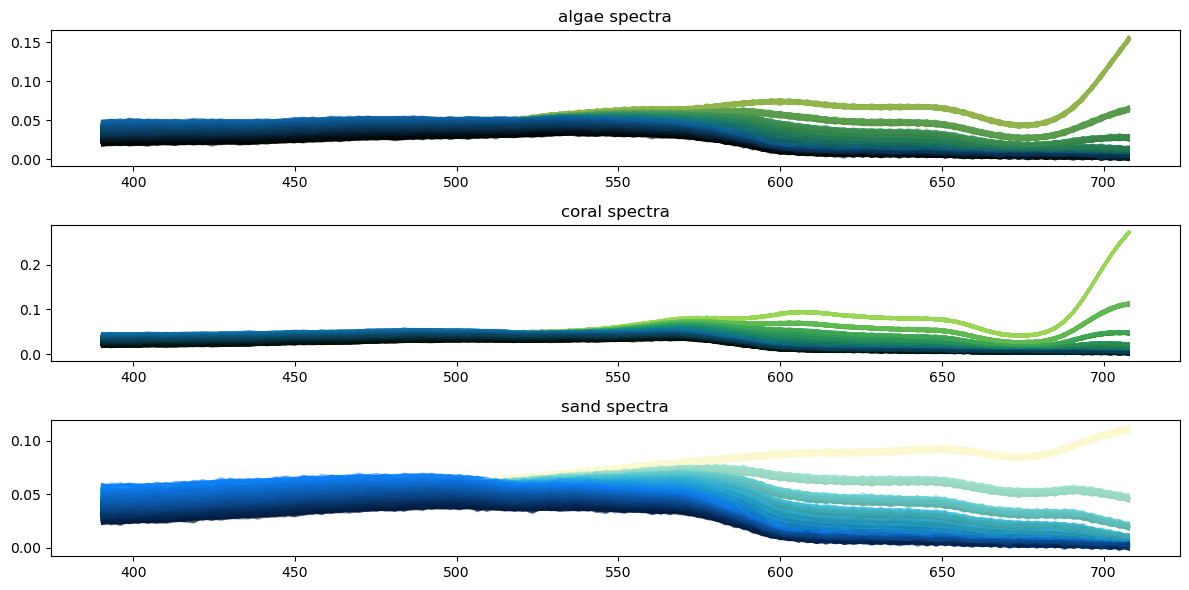

In [ ]:
# plot spectra in RGB space
subset_interval = 10

fig, axes = plt.subplots(nrows=3, figsize=(12, 6))

for s, (spectra, spectra_title) in enumerate(zip([algae_sim_spectra, coral_sim_spectra, sand_sim_spectra], ["algae", "coral", "sand"])):
    # flatten spectrum
    flat_spectra = spectra.reshape(-1, 113)
    for i, spectrum in tqdm(enumerate(flat_spectra[::subset_interval]), total=len(flat_spectra[::subset_interval])):
        axes[s].plot(wvs, spectrum, color=norm_rgb_values[len(spectra.reshape(-1, 113))*s:(s+1)*len(spectra.reshape(-1, 113))][::subset_interval][i], alpha=0.5)
        
    axes[s].set_title(f"{list(three_em_cats.keys())[s]} spectra")
        
plt.tight_layout()

# Colour visualisation